In [1]:
import nengo
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from nengo.dists import Choice
from datetime import datetime
import pickle
from nengo.utils.matplotlib import rasterplot
import time
from utilis import *
import random
import logging

In [ ]:
sim_time = 1200
vprog = 0 
for freq in [25,50,100,200]:
 
    for tau_rc in [0.2]:
        
        experiment_name = 'freq ' + str(freq)+ ' Hz & tau_rc_post  '+str(tau_rc*1000)+'ms'
        
        model = nengo.Network()
        with model:

        
            pre = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0], neuron_type=MyLIF_in(tau_rc=tau_rc,min_voltage=-1))

            post = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], max_rates=[freq], intercepts=[0],
                                  neuron_type=nengo.StochasticSpiking(nengo.LIFRate(tau_ref=1/1000)))

            stim_pre = nengo.Node(lambda t: 1)
            stim_post = nengo.Node(lambda t: 1)

            nengo.Connection(stim_pre, pre, synapse=None)
            nengo.Connection(stim_post, post, synapse=None)
    
            w = nengo.Node(CustomRule_post_v2_history(winit_min=0, winit_max=1,sample_distance=1,vprog=vprog,lr=100), size_in=1, size_out=1 )
            nengo.Connection(pre.neurons, w, synapse=None)
            nengo.Connection(w, post.neurons, transform=[0],synapse=None) #Spikes not transmitted

            p_stim_pre = nengo.Probe(stim_pre)
            p_stim_post = nengo.Probe(stim_post)
            p_pre = nengo.Probe(pre.neurons)
            p_post = nengo.Probe(post.neurons)
            p_pre_v = nengo.Probe(pre.neurons, 'voltage')

            weights = w.output.history
            dw = w.output.update_history

        sim = nengo.Simulator(model)
        
        w.output.set_signal_vmem(sim.signals[sim.model.sig[pre.neurons]["voltage"]])
        w.output.set_signal_out(sim.signals[sim.model.sig[post.neurons]["out"]])

        sim.run(sim_time)  

        pre_data = (sim.data[p_pre]/1000)[:,0]
        post_data = (sim.data[p_post]/1000)[:,0]
        pre_voltage_data = (sim.data[p_pre_v])[:,0]
        t_data = sim.trange()
        w_data = np.array(weights)[:,0,0]
        # w_data = np.clip(w_data,0,1)

        dw_data = np.array(dw)[:,0,0]/100
        
        
        pre_spike_times = t_data[np.where(pre_data == 1)]
        post_spike_times = t_data[np.where(post_data == 1)]

        dw_at_post = dw_data[np.where(post_data == 1)]
        dw_at_post = np.clip(dw_at_post,-1,1)
        w_at_post = w_data[np.where(post_data == 1)]
        w_at_post = w_at_post - dw_at_post
        w_at_post = np.clip(w_at_post,0,1)

        vmem_at_post = pre_voltage_data[np.where(post_data == 1)]


        tau_pre_nearest = np.ones((len(post_spike_times)))
        for i in range(len(post_spike_times)):
            tau_post = post_spike_times[i]
            neurest_index = (np.abs(pre_spike_times-tau_post)).argmin()
            tau_pre = pre_spike_times[neurest_index]
            tau_pre_nearest[i]=tau_pre
        dtau = post_spike_times - tau_pre_nearest

        
        
        fig_dir = os.getcwd()
        
        
        fig = plt.figure(figsize=(7,2))

        ax1 = fig.add_subplot(1,3,1)
        plt.scatter(dtau*1000, dw_at_post,c=w_at_post,s=1)
#         plt.title(experiment_name)
        cbar = plt.colorbar()
        cbar.set_label('W')
        ax1.set_xlabel('tau_post-tau_pre (ms)')
        ax1.set_ylabel('dW')
        
        
        ax2 = fig.add_subplot(1,3,2)
        ax2.scatter(vmem_at_post, dw_at_post,c=w_at_post, s=1)
        cbar = plt.colorbar()
        cbar.set_label('W')
        ax2.set_xlabel('Vmem(V)')
        ax2.set_ylabel('dW')
        
        ax3 = fig.add_subplot(1,3,3)
        ax3.scatter(vmem_at_post, dtau*1000, s=1)
        ax3.set_xlabel('Vmem(V)')
        ax3.set_ylabel('tau_post-tau_pre (ms)')
        
        fig.tight_layout()
        fig.savefig(fig_dir+ '/vdsp_curve '+experiment_name + '.jpeg',bbox_inches='tight',dpi=500)
        plt.close()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

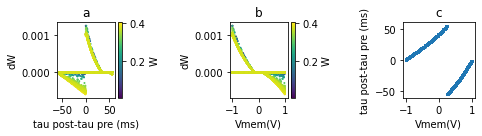

In [3]:
fig = plt.figure(figsize=(7,2))

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('a')
plt.scatter(dtau*1000, dw_at_post,c=w_at_post,s=1)
#         plt.title(experiment_name)
cbar = plt.colorbar()
cbar.set_label('W')
ax1.set_xlabel('tau post-tau pre (ms)')
ax1.set_ylabel('dW')


ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('b')

ax2.scatter(vmem_at_post, dw_at_post,c=w_at_post, s=1)
cbar = plt.colorbar()
cbar.set_label('W')
ax2.set_xlabel('Vmem(V)')
ax2.set_ylabel('dW')

ax3 = fig.add_subplot(1,3,3)
ax3.title.set_text('c')

ax3.scatter(vmem_at_post, dtau*1000, s=1)
ax3.set_xlabel('Vmem(V)')
ax3.set_ylabel('tau post-tau pre (ms)')

fig.tight_layout()
fig.savefig(fig_dir+ '/vdsp_curve '+experiment_name + '.jpeg',bbox_inches='tight',dpi=500)
# plt.close()

In [ ]:
ax1.title.set_text('a')


In [ ]:
wmax = 1/10
winit = 1/5
lr = 0.1
model = nengo.Network()
with model:

    bell = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0], neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))
    food = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0], neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))
    saliva = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0],neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))

    stim_food = nengo.Node(lambda t: 1 if 2<t%10<4 else 0)
    stim_bell = nengo.Node(lambda t: 1 if (3<t%10<6 or 1<t%10<2) else 0)

    nengo.Connection(stim_food, food, synapse=None)
    nengo.Connection(stim_bell, bell, synapse=None)

    w = nengo.Node(CustomRule_post_v4(winit_min=winit,winit_max=winit, sample_distance=1, lr=0.3), size_in=1, size_out=1)  
    nengo.Connection(bell.neurons, w, synapse=None)
    nengo.Connection(w, saliva.neurons,transform=[wmax], synapse=None)

    nengo.Connection(food.neurons, saliva.neurons,transform=[wmax*0.5], synapse=None)

    p_bell = nengo.Probe(bell.neurons)
    p_food = nengo.Probe(food.neurons)    
    p_saliva = nengo.Probe(saliva.neurons)
    p_saliva_v = nengo.Probe(saliva.neurons, 'voltage')

    weights = w.output.history

sim = nengo.Simulator(model)

# w.output.set_signal(sim.signals[sim.model.sig[saliva.neurons]["voltage"]])
w.output.set_signal_vmem(sim.signals[sim.model.sig[bell.neurons]["voltage"]])
w.output.set_signal_out(sim.signals[sim.model.sig[saliva.neurons]["out"]])

sim.run(6)  

plt.figure(figsize=(7,7))

plt.subplot(4, 1, 1)
plt.title('a')

plt.plot(sim.trange(), sim.data[p_bell]/500, c='k', label='spikes')
plt.ylabel('bell')
plt.xlabel("Time[s]")
plt.legend()

plt.subplot(4, 1, 2)
plt.title('b')
plt.plot(sim.trange(), sim.data[p_food]/500, c='k', label='spikes')
plt.ylabel('food')
plt.xlabel("Time[s]")
plt.legend()

plt.subplot(4, 1, 3)
plt.title('c')
plt.plot(sim.trange(), sim.data[p_saliva]/500, c='k', label='spikes')
plt.plot(sim.trange(), sim.data[p_saliva_v], label='voltage')
plt.ylabel('saliva')
plt.xlabel("Time[s]")
plt.legend()

plt.subplot(4, 1, 4)
plt.title('d')
plt.plot(sim.trange(), np.array(weights)[:,:,0], label='weight_bell')
plt.xlabel("Time[s]")
plt.ylabel("(w/wmax)")
plt.legend()

plt.tight_layout()
plt.savefig('dog'+'winit'+str(winit)+'wmax'+str(wmax)+'lr'+str(lr)+'.jpeg', dpi=400)
# plt.close()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.